# Antrenarea unei retele de clasificare

Obiectivul acestui laborator este de a introduce conceptele de baza necesare antrenarii unei retele neuronale. Pytorch ofera posibilitatea de a incarca si procesa setul de date rapid si eficient. In acest laborator vom folosi setul de date CIFAR-10, pentru care vom rezolva problema de clasificare.

Importarea bibliotecilor care vor fi folosite in acest laborator:

 * *matplotlib.pyplot* pentru grafice
 * *torch.optim* pentru optimizatori
 * *torch.nn* pentru lucrul cu retele neurale
 * *torch.utils.data* pentru lucrul cu seturi de date
 * *torchvision* pentru seturi de date oferite de repository-ul Pytorch

In [ ]:
from IPython import display as dspl

import time

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torchvision

## Dataset
Clasa *torchvision.datasets.CIFAR10* este o subclasa a clasei abstracte *torch.utils.data.Dataset*. O astfel de clasa este folosita pentru a ingloba datasetul si pentru a returna elemente din dataset.

O clasa derivata din *torch.utils.data.Dataset*, trebuie sa suprascrie 2 metode:
 * \_\_len\_\_(self) -> aceasta metoda returneaza numarul de elemente din dataset si permite folosirea functiei __len()__ din Python.
 * \_\_getitem\_\_ -> permite folosirea operatorului de indexare din Python __[ ]__ pentru a obtine un element de la un anumit index din dataset 

### Cerinte
  1. Printati numarul de exemple din datasetul de antrenare si de test
  2. Printati exemplul de la indexul 0
  3. Printati valoarea maxima si valoarea minima din prima imagine din datasetul de test

#### Hints
 * Un exemplu din dataset este reprezentat de un tuplu care contine o imagine de tip de date PIL.Image si un int reprezentand clasa imaginii
 * np.min(a) -> returneaza minimul dintr-un obiect de tipul np.ndarray
 * np.max(a) -> returneaza maximul dintr-un obiect de tipul np.ndarray
 * np.asarray(a) -> returneaza un obiect de tipul np.ndarray. Functia trebuie sa primeaca un obiect 'array-like'

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
50000
10000


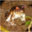

6
13 255


In [ ]:
# Crearea instantelor pentru setul de date CIFAR de train si de test
cifar_train = torchvision.datasets.CIFAR10("./data", download=True)
cifar_test = torchvision.datasets.CIFAR10("./data", train=False)

#TODO: Scrieti aici codul pentru cerinta numarul 1
print(len(cifar_train))
print(len(cifar_test))
#TODO: Scrieti aici codul pentru cerinta numarul 2
display(cifar_train[0][0])
print(cifar_train[0][1])
#TODO: Completati sub codul pentru cerinta numarul 3
arr = np.asarray(cifar_test[0][0])
print(np.min(arr), np.max(arr))

## Iterare prin Dataset

Deoarece clasa datasetului implementeaza functia \_\_getitem\_\_(), se poate itera prin dataset cum se poate itera si printr-o lista sau alt obiect iterabil. 

### Cerinte
 * Odata la n pasi, printati clasa exemplului curent si afisati imaginea.

#### Hints
  * A fost importata libraria matplotlib.pyplot as plt
  * Functia plt.figure(figsize=(float, float)) returneaza o figura de dimensiunea oferita ca parametru in *figsize*
  * Functia plt.imshow(np.ndarray) plaseaza o imagine pe o figura
  * Functia plt.show() afiseaza figura

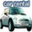

1


In [ ]:
n = 10000

for idx, example in enumerate(cifar_train):
  if idx % n == 0:
    # Aceasta functie sterge ce a fost afisat pana la momentul curent
    dspl.clear_output(wait=True)
  
    #TODO: Completati codul aici si afisati cateva imagini din dataset
    display(example[0])
    print(example[1])
    # Aceasta functie opreste procesul pentru 2 secunde 
    time.sleep(2)

## DataLoader

In torch.utils.data este definita clasa *DataLoader*. Aceasta este un wrapper peste o clasa de tip Dataset si este folosita pentru a abstractiza procesarea pe mai mult threaduri, concatenarea exemplelor in batch-uri, si extragerea exemplelor in mod aleatoriu din dataset.

Pentru a crea un obiect de tip *DataLoader* se foloseste constructorul care are urmatorul header:

  \_\_init\_\_(dataset_object, batch_size=1, shuffle=False, num_workers=0, collate_fn=None)

 * dataset_object - obiectul de tip Dataset care va fi inglobat
 * batch_size - dimensiunea batch-ului care va fi returnat
 * shuffle - determina daca exemplele vor fi extrase aleatoriu sau nu
 * num_workers - numarul de procese paralele care vor incarca datele
 * collate_fn - o functie care face preprocesari pe N elemente returnate de obiectul de tip Dataset si le concateneaza intr-un batch. N = batch_size

Clasa DataLoader implementeaza si functia *\_\_len\_\_()* pentru a returna numarul de batch-uri din dataset.

Obiectul de tip Dataset creat anterior returneaza un tuple-uri care contin o imagine de tip PIL.Image si clasa imaginii de tip int. O retea neurala din Pytorch opereaza pe tipul de date torch.Tensor. Prin urmare obiectul de tip DataLoader trebuie sa returneze obiecte de tip torch.Tensor 

### Cerinte
  1. Iterati prin cele doua obiecte de tip DataLoader si printati doar primul element.
  2. Printati shape-ul celor 2 tensori  doar pentru primul element

#### Hints
  * functia __to_tensor__ din *torchvision.transforms.functional* creaza un obiect de tip torch.Tensor dintr-un obiect de tip PIL.Image
  * functia __torch.tensor__ creaza un obiect de tip torch.Tensor dintr-un obiect de tip np.ndarray
  * functia __unsqueeze()__ din clasa torch.Tensor creaza o noua dimensiune intr-un tensor. Aceasta este echivalentul functiei __expand_dims()__ din numpy. Exemplu: Daca avem un obiect de tip torch.Tensor, *t*, care contine un vector cu 10 elemente (shape [10]), *t.unsqueeze(0)* va returna un boiect cu aceleasi valori dar cu shape-ul [1, 10]
  * functia __torch.cat(tensors, dim=0)__ primeste o lista de tensori si ii concateneaza de-a lungul dimensiunii *dim*. Exemplu: functia primeste o lista cu doi vectori cu shape-ul [1, 10] si *dim=0*, rezultatul are shape-ul [2, 10] (batch 2 ?). Daca *dim=1*, rezultatul va fi [1, 20]. Echivalentul numpy este functia __concatenate()__
  * functia __size()__ din clasa torch.Tensor returneaza shape-ul tensorului

In [ ]:
from torchvision.transforms.functional import to_tensor

def preproc_fn(examples):
  """
    Functia primeste un batch de exemple pe care trebuie sa le transforme in tensori
      si sa le puna intr-un batch de tip torch.Tensor.
  """
  processed_images = []
  processed_labels = []
  

  for example in examples: # example este un tuplu returnat de obiectul de tip Dataset
    pil_image = example[0]
    pil_image_array = np.asarray(pil_image)

    tensor_image = to_tensor(pil_image)  # Transforma in obiect de tip torch.Tensor imaginea din example
    tensor_image = tensor_image.unsqueeze(0) # Adauga inca o dimensiune la inceputul imaginii
    processed_images.append(tensor_image)

    label = np.array([example[1]])# Creaza un obiect de tip np.ndarray din labelul exemplului
    tensor_label = torch.Tensor(label)# Creaza un obiect de tip torch.Tensor din label
    tensor_label = tensor_label.unsqueeze(0) # Adauga inca o dimensiune la incepului labelului
    processed_labels.append(tensor_label)

  torch_images = torch.cat(processed_images,  dim=0)
  torch_labels = torch.cat(processed_labels, dim=0)

  return torch_images, torch_labels

loader1 = data.DataLoader(cifar_train, batch_size=1000, shuffle=True, collate_fn=preproc_fn)

print("Datasetul contine {} de batch-uri".format(len(loader1)))
# print(len(loader1))
loader2 = data.DataLoader(cifar_train, batch_size=1000, shuffle=True, num_workers=2, collate_fn=preproc_fn)

start = time.time()
for index, batch in enumerate(loader1):
#TODO: Cerintele 1 si 2 - Iterati prin loader1 si printati doar primul element si shape-ul celor 2 tensori din exemplu
  if index == 0:
    print(batch)
    print(batch[0].shape)
    print(batch[1].shape)
  
end = time.time()
print("Iterarea prin dataset cu worker-ul pe procesul curent dureaza {} secunde".format(end - start))

start = time.time()

for index, batch in enumerate(loader2):
#TODO: Cerintele 1 si 2 - Iterati prin loader2 si printati doar primul element si shape-ul celor 2 tensori din exemplu
  if index == 0:
    print(batch)
    print(batch[0].shape)
    print(batch[1].shape)
end = time.time()
print("Iterarea prin dataset cu 2 worker-i pe procese diferinte dureaza {} secunde".format(end - start))

Datasetul contine 50 de batch-uri
(tensor([[[[0.6745, 0.6863, 0.6863,  ..., 0.7451, 0.7647, 0.7765],
          [0.6510, 0.6510, 0.6627,  ..., 0.6549, 0.7098, 0.7529],
          [0.6353, 0.6235, 0.6314,  ..., 0.5961, 0.6118, 0.6588],
          ...,
          [1.0000, 0.9922, 0.9961,  ..., 0.9373, 0.9922, 0.9961],
          [1.0000, 0.9961, 0.9961,  ..., 0.9686, 0.9922, 0.9961],
          [1.0000, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961]],

         [[0.7686, 0.7804, 0.7804,  ..., 0.8157, 0.8275, 0.8275],
          [0.7451, 0.7451, 0.7569,  ..., 0.7490, 0.7922, 0.8275],
          [0.7333, 0.7176, 0.7255,  ..., 0.7137, 0.7176, 0.7529],
          ...,
          [1.0000, 0.9922, 0.9961,  ..., 0.9412, 0.9922, 0.9961],
          [1.0000, 0.9961, 0.9961,  ..., 0.9686, 0.9922, 0.9961],
          [1.0000, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961]],

         [[0.7843, 0.7961, 0.7961,  ..., 0.8275, 0.8431, 0.8510],
          [0.7608, 0.7608, 0.7725,  ..., 0.7569, 0.8078, 0.8471],
       

## Definirea unei retele cu un singur layer

Modulul *torch.nn* contine clase si functii utilitare pentru crearea retelelor neurale. Pentru a crea o retea neurala se va defini o clasa, *SingleLayerNet* ce mosteneste din clasa *torch.nn.Module*. Clasele din Pytorch ce definesc straturi, functii de activare, si functii cost mostenesc din clasa *torch.nn.Module*. Aceste clase implementeaza metoda **forward()** care este folosita pentru a defini ce se intampla la un forward pass. Aceasta metoda este apelata in metoda __\_\_call\_\_()__ a clasei.

Clasa *Linear* din *torch.nn*, ce mosteneste din *nn.Module* defineste un strat 'fully-connected'. Contructorul primeste 3 parametrii:
 * Dimensiunea vectorului de intrare
 * Dimensiunea vectorului de iesire
 * Daca sa se foloseasca *bias* sau nu

Clasa Simgoid din *torch.nn* , ce mosteneste din *nn.Module*, defineste o functie de activare sigmoid.

### Cerinte
  1. In constructorul clasei *SingleLayerNet* definiti un atribut care sa contina un obiect de tip *nn.Linear*
  2. In constructorul clase *SingleLayerNet* definiti un atribut care sa contina un obiect de tip *nn.Sigmoid*
  3. In metoda __forward()__ definiti o variabila care sa contina iesirea stratului linear aplicat pe intrarea 'x'.
  4. In metoda __forward()__ definiti o variabila care sa contina iesirea functiei de activare sigmoid aplicata pe iesirea stratului linear si returnati aceasta variabila

#### Hint
 * Imaginea de intrare are dimensiune 32x32x3 (inaltime x latime x canale). Vectorul de intrare in retea va avea dimensiune 3072.

#### Atentie
 * Dimensiunea de iesire a stratului trebuie sa fie de aceeasi marime cu numarul de clase.

In [ ]:
### Exemplu utilizare metoda __call__()
class A(object):
  def __init__(self):
    self.a ='A'

  def __call__(self, mesaj):
    print(self.a, mesaj)

obj = A()
obj("OK!")

A OK!


In [ ]:
import torch.nn as nn

class SingleLayerNet(nn.Module):

  def __init__(self):
    super(SingleLayerNet, self).__init__()

    #TODO: Cerinta 1 - completati codul aici
    self.linear1 = nn.Linear(3072, 10, True)
    
    #TODO: Cerinta 2 - completati codul aici
    self.activation1 = nn.Sigmoid()

  def forward(self, x: torch.Tensor):
    #TODO: Cerinta 3 si 4 - completati codul aici
    output_linear = self.linear1(x)
    output = self.activation1(output_linear)
    output = torch.squeeze(output)
    
    return output



# Definirea unei retele cu doua straturi (layere).

### Cerinte
  1. In constructorul clasei *TwoLayerNet* definiti doua atribute care sa contina doua obiecte de tip *nn.Linear*. 
  2. In constructorul clasei *TwoLayerNet* definiti un atribut care sa contina un obiect de tip *nn.Sigmoid* (se poate folosi acelasi obiect de tip *nn.Sigmoid* pentru activarea ambelor straturi *nn.Linear*)
  3. Implementati metoda **forward()** similar cu exercitul anterior (layer1->activation->layer2->activation).



In [ ]:
class TwoLayerNet(nn.Module):

  def __init__(self):
    super(TwoLayerNet, self).__init__()
    # Cerinta 1 - completati codul aici
    self.linear1 = nn.Linear(3072, 768, True)
    self.linear2 = nn.Linear(768, 10, True)

    # Cerinta 2 - completati codul aici
    self.activation1 = nn.Sigmoid()

  def forward(self, x: torch.Tensor):
    # Cerinta 3 si 4- completati codul aici
    output_linear1 = self.linear1(x)
    output1 = self.activation1(output_linear1)
    output_linear2 = self.linear2(output1)
    output2 = self.activation1(output_linear2)
    print(output2.shape)
    output2 = torch.squeeze(output2)
    return output2
    

## Preprocesare pentru retele cu straturi 'fully-connected'

Avand o retea cu straturi 'fully-connected' este necesar ca imaginea sa fie redimensionata intr-un vector. Clasa *torch.Tensor* defineste metoda __view()__ care returneaza un tensor redimensionat.

### Cerinte
  1. Completati functia de mai jos pentru a redimensiona imaginea intr-un vector.
  2. Extrageti un batch din DataLoader-ul de antrenare si printati dimensiunile imaginii.

In [ ]:
# Varianta numpy

img1 = np.random.rand(32, 32, 3)
img2 = np.random.rand(32, 32, 3)

print(img1.shape, img2.shape)

reshaped1 = img1.reshape(-1)
reshaped2 = img2.reshape(32*32*3)

print(reshaped1.shape, reshaped2.shape)

(32, 32, 3) (32, 32, 3)
(3072,) (3072,)


In [ ]:
from torchvision.transforms.functional import normalize

def preproc_liniarized_fn(examples):
  processed_images = []
  processed_labels = []

  for example in examples:
    tensor_image = to_tensor(example[0])
    # In linia de mai jos imaginea este normalizata astfel incat sa aiba toate valorile in 
    # [-1, 1] in loc de [0, 255]
    normalized_tensor_image = normalize(tensor_image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    #TODO: Cerinta 1 - completati codul aici 
    vector_image = normalized_tensor_image.resize_(1, 3072)
    vector_image = vector_image.unsqueeze(0)
    processed_images.append(vector_image)
    
    label = np.array(example[1])
    tensor_label = torch.tensor(label)
    tensor_label = tensor_label.unsqueeze(0)
    processed_labels.append(tensor_label)

  torch_images = torch.cat(processed_images, dim=0)
  torch_labels = torch.cat(processed_labels, dim=0)

  return torch_images, torch_labels

batch_size = 100

train_loader = data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=preproc_liniarized_fn)
test_loader = data.DataLoader(cifar_test, batch_size=1, shuffle=False, collate_fn=preproc_liniarized_fn)

#TODO: Cerinta 2 - completati codul aici

for index, batch in enumerate(train_loader):
    print(batch[0][0].shape)
    break

torch.Size([1, 3072])


## Definirea antrenarii

Pentru definirea antrenarii avem urmatorii pasi:
 * Definirea numarului de epoci (de cate ori parcurgem intregul dataset)
 * Definirea obiectului de tip *SingleLayerNet*
 * Definirea optimizatorului. Vom folosi Stochastic Gradient Descent (SGD) pentru optimizarea retelei, prin urmare definim un obiect de tip *optim.SGD*. Constructorul acestei clase primeste parametrii pe care trebuie sa-i optimizeze (single_layer_net.parameters()) si rata de invatare (lr=1e-2)
 * Definim functia cost de tip *nn.CrossEntropyLoss()*
 * Definim functa care parcurge datasetul si antreneaza reteaua.

In [ ]:
import torch.optim as optim

# Definim numarul de epoci
epochs = 10

# Definim reteaua
single_layer_net = SingleLayerNet()

# Definim optimizatorul
optimizer = optim.SGD(single_layer_net.parameters(), lr=1e-2)
# Dupa definirea optimizatorului si dupa fiecare iteratie trebuie apelata functia zero_grad().
# Aceasta face toti gradientii zero.
optimizer.zero_grad()

# Definim functia cost
loss_fn = nn.CrossEntropyLoss()

def train_fn(epochs: int, train_loader: data.DataLoader, test_loader: data.DataLoader, 
             net: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer):
  # Iteram prin numarul de epoci
  for e in range(epochs):
    # Iteram prin fiecare exemplu din dataset
    for images, labels in train_loader:

      # Aplicam reteaua neurala pe imaginile de intrare
      out = net(images)
      # Aplicam functia cost pe iesirea retelei neurale si pe adnotarile imaginilor 
      loss = loss_fn(out, labels)
      # Aplicam algoritmul de back-propagation
      loss.backward()
      # Facem pasul de optimizare, pentru a aplica gradientii pe parametrii retelei
      optimizer.step()
      # Apelam functia zero_grad() pentru a uita gradientii de la iteratie curenta
      optimizer.zero_grad()
    
    print("Loss-ul la finalul epocii {} are valoarea {}".format(e, loss.item()))

    # Calculul acuratetii
    count = len(test_loader)
    correct = 0

    for test_image, test_label in test_loader:
      out_class = torch.argmax(net(test_image))
      if out_class == test_label:
        correct += 1

    print("Acuratetea la finalul epocii {} este {:.2f}%".format(e, (correct / count) * batch_size))

## Antrenam propria retea

In [ ]:
train_fn(epochs, train_loader, test_loader, single_layer_net, loss_fn, optimizer)

Loss-ul la finalul epocii 0 are valoarea 2.1009716987609863
Acuratetea la finalul epocii 0 este 32.32%
Loss-ul la finalul epocii 1 are valoarea 2.1066884994506836
Acuratetea la finalul epocii 1 este 33.72%
Loss-ul la finalul epocii 2 are valoarea 2.067763090133667
Acuratetea la finalul epocii 2 este 34.35%
Loss-ul la finalul epocii 3 are valoarea 2.087510108947754
Acuratetea la finalul epocii 3 este 34.89%
Loss-ul la finalul epocii 4 are valoarea 2.0375022888183594
Acuratetea la finalul epocii 4 este 35.10%
Loss-ul la finalul epocii 5 are valoarea 2.072293519973755
Acuratetea la finalul epocii 5 este 35.21%
Loss-ul la finalul epocii 6 are valoarea 2.051403284072876
Acuratetea la finalul epocii 6 este 35.62%
Loss-ul la finalul epocii 7 are valoarea 1.9830405712127686
Acuratetea la finalul epocii 7 este 35.84%
Loss-ul la finalul epocii 8 are valoarea 2.064542055130005
Acuratetea la finalul epocii 8 este 36.08%
Loss-ul la finalul epocii 9 are valoarea 2.0499651432037354
Acuratetea la fina

## Definirea unei retele cu 2 straturi si antrenarea ei

### Cerinte
 1. Instantiati un obiect de tip *TwoLayerNet*.
 2. Definiti un optimizator pentru antrenarea acestei retele
 3. Folositi functia deifnita mai sus pentru a antrena aceasta retea (*train_fn*).

#### Atentie
 * Dimensiunea de iesire a primului strat trebuie sa se potriveasca cu dimensiunea de intrare a celui de-al doilea.

In [ ]:
#TODO: Cerinta 1 - completati codul aici

# Instantierea retelei
two_layer_net = TwoLayerNet()

#TODO: Cerinta 2 - completati codul aici
optimizer2 = optim.SGD(two_layer_net.parameters(), lr=0.001, momentum=0.7)

# Dupa definirea optimizatorului si dupa fiecare iteratie trebuie apelata functia zero_grad().
# Aceasta face toti gradientii zero.
optimizer2.zero_grad()

# Definim functia de cost
loss_fn2 = nn.CrossEntropyLoss()

#TODO: Cerinta 3 - Antrenati reteaua
# input_train = train_loader
train_fn(epochs, train_loader, test_loader, two_layer_net, loss_fn2, optimizer2)

## Crearea dinamica a unei retele

In  *torch.nn* exista clasa *Sequential* care primeste o lista de straturi si functii de activare in ordinea in care trebuie aplicate, e.g. [linear, sigmoid, linear, sigmoid]. Rezultatul este inlantuirea acestor straturi si functii de activare.


In [ ]:
class Net(nn.Module):

  def __init__(self, layer_sizes: list, activation: type):
    """
      Constructor.

      :param layer_sizes - Parametru de tip lista care contine dimensiunile fiecarui strat din retea
      :param activation - Parametru de tip type. Poate fi nn.Sigmoid, nn.Tanh, nn.ReLU. Adica clasa pentru a instantia mai tarziu
    """
    super(Net, self).__init__()
    
    layers = []

    for i in range(0, len(layer_sizes)):
      print(layer_sizes[i])
      inl, out = layer_sizes[i]
      layers.append(nn.Linear(inl, out))
      layers.append(activation)

    self.net = nn.Sequential(*layers)
    print(self.net)
  def forward(self, x: torch.Tensor):
    return self.net(x)

## [BONUS] Antrenarea retelei cu N straturi

Mai jos functia de antrenare a fost modificata pentru a afisa modificarile parametrilor retelei in timpul antrenarii. Aceasta se obtine prin implementarea functiei __plot_weights()__.

### Cerinte 

  1. Creati un obiect de tipul *Net*
  2. Creati un optimizator pentru reteaua de tipul *Net*
  3. Antrenati reteaua folosind functia __plotting_train_fn()__
  4. Experimentati cu retele straturi si functii de activare diferite
  5. Modificati celula de mai jos si scrieti o functie numita __plot_loss()__ pentru a afisa un grafic care arata evolutia rezultatului functiei cost in timp. Faceti acelasi lucru si pentru acuratete.

(3072, 3072)
(3072, 10)
Sequential(
  (0): Linear(in_features=3072, out_features=3072, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=3072, out_features=10, bias=True)
  (3): Sigmoid()
)
Loss-ul la finalul epocii 0 are valoarea 2.2837255001068115
Acuratetea la finalul epocii 0 este 17.71%


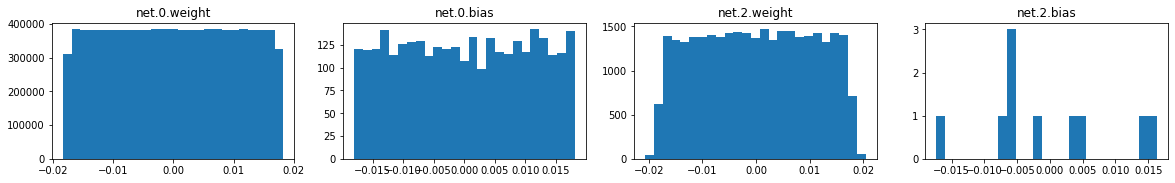

Loss-ul la finalul epocii 1 are valoarea 2.274474859237671
Acuratetea la finalul epocii 1 este 21.91%


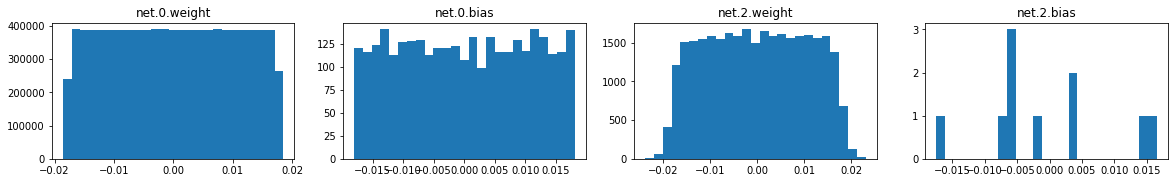

Loss-ul la finalul epocii 2 are valoarea 2.2502026557922363
Acuratetea la finalul epocii 2 este 25.04%


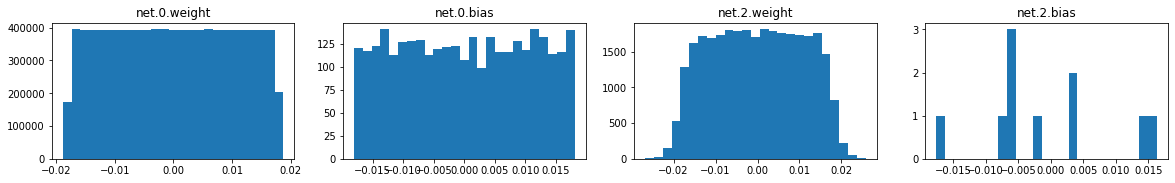

Loss-ul la finalul epocii 3 are valoarea 2.2527706623077393
Acuratetea la finalul epocii 3 este 26.07%


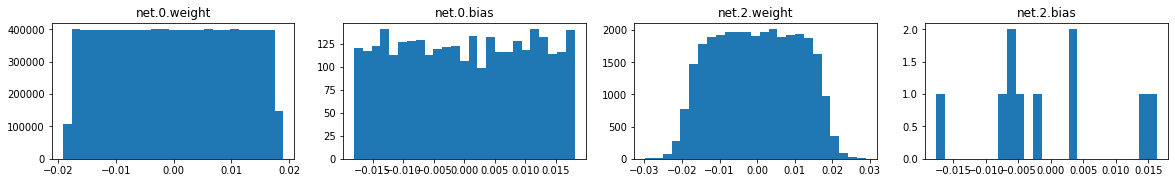

Loss-ul la finalul epocii 4 are valoarea 2.1995131969451904
Acuratetea la finalul epocii 4 este 26.84%


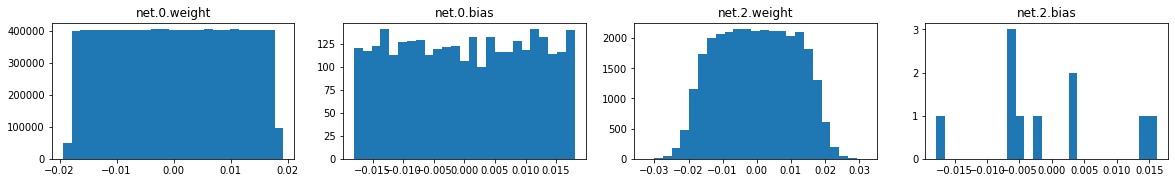

Loss-ul la finalul epocii 5 are valoarea 2.2129664421081543
Acuratetea la finalul epocii 5 este 26.25%


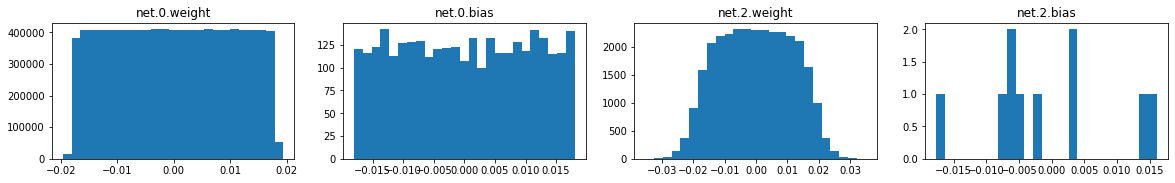

Loss-ul la finalul epocii 6 are valoarea 2.1842305660247803
Acuratetea la finalul epocii 6 este 27.75%


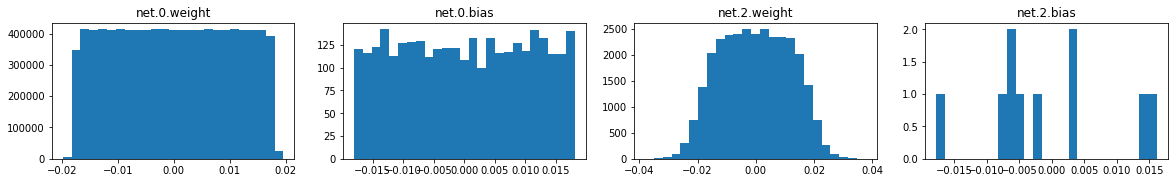

Loss-ul la finalul epocii 7 are valoarea 2.1987428665161133
Acuratetea la finalul epocii 7 este 28.70%


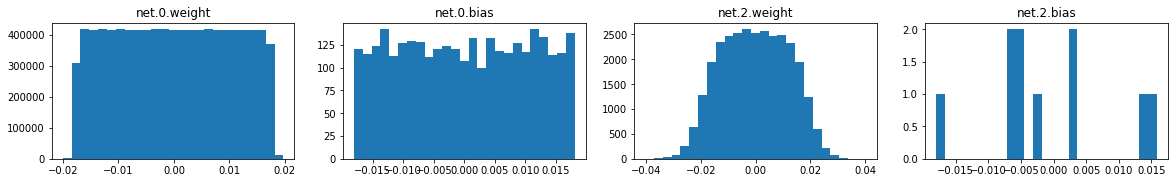

Loss-ul la finalul epocii 8 are valoarea 2.1445114612579346
Acuratetea la finalul epocii 8 este 27.86%


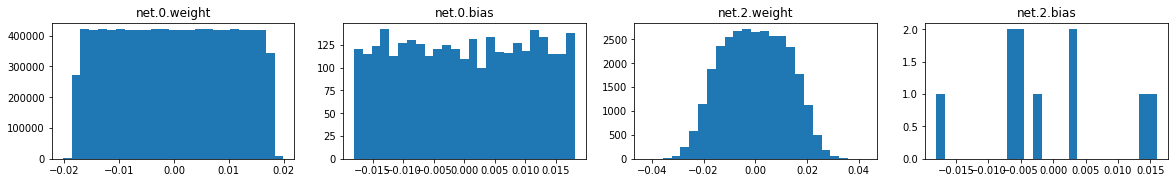

Loss-ul la finalul epocii 9 are valoarea 2.155858278274536
Acuratetea la finalul epocii 9 este 29.56%


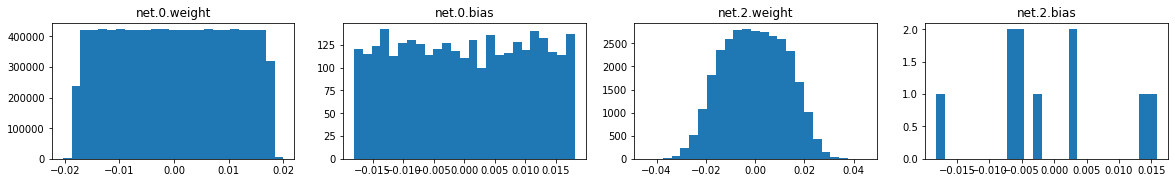

In [ ]:
def plot_weights(net: nn.Module):
  named_params = net.named_parameters()
  np_params = []
  np_param_names = []
  for name, param in named_params:
    np_params.append(param.clone().detach().view(-1).numpy())
    np_param_names.append(name)

  fig = plt.figure(figsize=(20, 2.5))

  count = len(np_param_names)
  for i in range(count):
    plt.subplot(1, count, i+1)
    plt.hist(np_params[i], bins=25)
    plt.title(np_param_names[i])
  plt.show()


def plotting_train_fn(epochs: int, train_loader: data.DataLoader, test_loader: data.DataLoader, 
             net: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer):
  for e in range(epochs):
    for images, labels in train_loader:
      # print(len(images[0][0]), len(labels))
      out = net(images)
      loss = loss_fn(out.squeeze(), labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
    
    print("Loss-ul la finalul epocii {} are valoarea {}".format(e, loss.item()))

    count = len(test_loader)
    correct = 0

    for test_image, test_label in test_loader:
      out_class = torch.argmax(net(test_image))
      if out_class == test_label:
        correct += 1
    
    print("Acuratetea la finalul epocii {} este {:.2f}%".format(e, (correct / count) * 100))
    plot_weights(net)

# Cerinta 1 - completati codul aici
# layer_sizes = [(3072, 768), (768, 1024), (1024, 512), (512, 256), (256, 64), (64, 10)]
# layer_sizes = [(3072, 768), (768, 192), (192, 48), (48, 10)]
layer_sizes = [(3072, 3072), (3072, 10)]
# layer_sizes = [(3072, 2048), (2048, 1024), (1024, 512), (512, 256), (256, 64)]
# layer_sizes = [(3072, 768), (768, 192), (192, 10)]
net = Net(layer_sizes, nn.Sigmoid())
# Cerinta 2 - completati codul aici
optimizer3 = optim.SGD(net.parameters(), lr=0.001, momentum=0.7)
optimizer3.zero_grad()
loss_fn3 = nn.CrossEntropyLoss()
# Cerinta 3 - completati codul aici

plotting_train_fn(epochs, train_loader, test_loader, net, loss_fn3, optimizer3)
# Cerinta 5 - completati codul aici
